<a href="https://colab.research.google.com/github/rtegao/CNN-Specialization/blob/master/T6_Transferencia_estilo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho #6 - Transferência de Estilo

Nesse trabalho você vai utilizar uma RNA pré-treinada para alterar estilo de uma imagem. A rede pré-treinada que será utilizada é a VGG19 que está disponível no Keras.

Nesse trabalho você vai fazer:

- Implementar o método de transferência de estilo;
- Gerar imagens com novos estilos de arte;
- Os algoritmos estudados até o momento minimizam uma função de custo para obter os parâmetros de uma RNA. Na transferência de estilo uma função de custo é minimizada para obter os valores dos pixels de uma imagem.

O método de transferência de estilo usado nesse trabalho foi criado por Gatys et al. (2015) (https://arxiv.org/abs/1508.06576).

O algortimo implementado nesse notebook foi desenvolvido por: https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb

## Coloque os nomes e RAs dos alunos que fizeram esse trabalho

Nome e número dos alunos da equipe:

Aluno 1: Ricardo Rossi Tegao 20.83988-0

Aluno 2: 

**Execute as duas células abaixo se você estiver usando o Coolab e as imagens estão no seu Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/My Drive/Specialization/Projects/Convolutional Neural Networks/T6 - Transferencia de Estilo
!ls

/content/drive/My Drive/Specialization/Projects/Convolutional Neural Networks/T6 - Transferencia de Estilo
Great_Wave_off_Kanagawa.jpg  sao_francisco.png
Green_Sea_Turtle.jpg	     T6_Transferencia_estilo_v2.ipynb
louvre.jpg		     Tytus_Brzozowski.png
monet_800600.jpg


## 1 - Definição do problema

A transferência de estilo realizada por uma rede neural (NST) é uma das técnicas mais interessantes de "deep-learning". Como visto em aula a NST mescla duas imagens, a imagem de "conteúdo" (**C**) e a imagem de "estilo" (**S**), para criar uma nova imagem "gerada" (**G**). A imagem gerada **G** combina o "conteúdo" da imagem **C** com o "estilo" da imagem **S**.

Neste trabalho você irá gerar uma imagem do museu do Louvre em Paris (imagem de conteúdo **C**) com o estilo de uma pintura de Claude Monet, líder do movimento impressionista (imagem de estilo **S**).

A transferência de estilo neural (NST) usa uma rede convolucional previamente treinada. Como já visto em aula, a idéia de usar uma rede pré-treinada em uma tarefa diferente e aplicá-la a uma nova tarefa é chamada de transferência de aprendizado.

Seguindo o trabalho original do NST (https://arxiv.org/abs/1508.06576) usaremos a rede VGG19, que é uma versão de 19 camadas da rede VGG. A VGG19 foi treinada no banco de dados ImageNet que possui milhões de imagens e, portanto, é capaz de reconhecer uma grande variedade de características de baixo nível (presentes nas camadas iniciais da RNA) e de alto nível (presentes nas camadas mais profundas).

## 2 - Preparação e inicialização do ambiente  e das imagens

### Importação das bibliotecas

Execute a célula abaixo para importar as bibliotecas necessárias para esse trabalho.

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools
import os
import sys

import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

### Visualização das imagens de entrada

Execute as células abaixo para definir e visualizar as imagens que serão mescladas. Essas são as imagens de conteúdo e de estilo. O que queremos é criar uma nova imagem com o conteúdo da imagem de "conteúdo" e com o estilo da imagem de "estilo".

In [0]:
# Definição de variáveis globais e visualização da simagens

content_path = 'louvre.jpg' 
style_path = 'monet_800600.jpg'

In [0]:
# Função para ler imagem e transformar em um array do TensorFlow

def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
  
    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)
    return img

In [0]:
# Função para mostrar imagem

def imshow(img, title=None):
    # Remove the batch dimension
    out = np.squeeze(img, axis=0)
    # Normalize for display 
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
        plt.imshow(out)

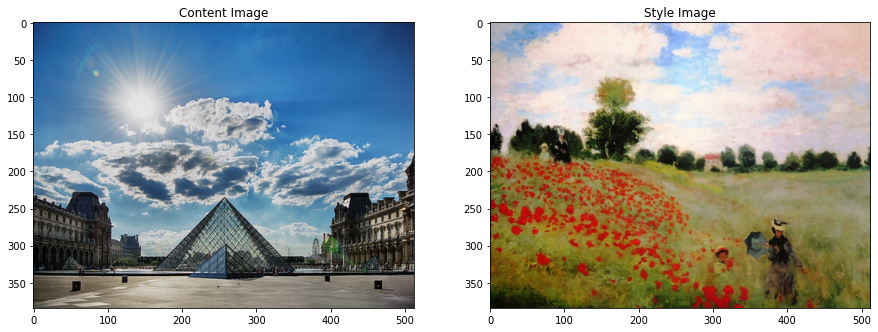

In [7]:
# Mostra as imagens de conteúdo e de estilo

plt.figure(figsize=(15,15))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## 2 - RNA convolucional base

Nesse trabalho você irá usar uma RNA convolucional já treinada para processar as imagens e extrair as ativações das camadas para formar as funções de custo de conteúdo e de estilo. A RNA que será usada como base é a VGG19 (Simonyan & Zisserman, Very deep convolutional networks for large-scale image recognition, 2015). 

Como já visto as RNAs VGG16 e VGG19 foram desenvolvidas para classificação de múltiplas classes com 1.000 classes. Ela é utilizadas para reconhecimento de objetos em imagens. A arquitetura das VGGs é muito simples, sendo composta pela repetição de camadas convolucionais formando blocos. Cada bloco é composto por duas ou três camadas convolucionais, com filtros 3x3, stride = 1 e “same convolution”, seguida por uma camada de max-pooling, com janela 2x2 e stride = 2. A VGG19 mantém praticamente o mesmo padrão em todos os blocos dobrando o número de filtros a cada bloco. Apesar da VGG19 possuir muitos parâmetros, cerca de 143 milhões, ela é muito simples.

### Exercício #1: Importação da RNA VGG19

O TensorFlow/keras possui na sua base de dados a RNA VGG19 treinada com o banco de imagens imagenet. Na célula abaixo carregue a VGG19 usando o comando do TensorFlow `tf.keras.applications.vgg19.VGG19`. Não se esqueça de excluir as camadas densas da VGG19 ao importá-la e de incluir os "weigths" desejados. Nesse caso não é preciso informar a dimensão da imagem de entrada nessa etapa.

In [8]:
# PARA VOCÊ FAZER: Carregar e salvar a VGG19 na rna-base

### COMECE AQUI ### (≈ 1 linha) 
rna = tf.keras.applications.vgg19.VGG19(include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",)
### TERMINE AQUI ###

rna.summary()

80142336/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

**Saída esperada:** Para conferência incluimos somente o número de parâmetros.

     Total params: 20,024,384
     Trainable params: 20,024,384
     Non-trainable params: 0

### Preparação dos dados

Precisamos criar funções que permitem carregar e pré-processar imagens para serem utilizadas pela rede VGG19. Devemos realizar o mesmo pré-processamento utilizado nas imagens processadas pela rede VGG19. A rede VGG19 é treinada com imagens onde cada canal RGB é normalizado usando as seguintes médias = [103,939, 116,779, 123,68].

Execute a célula abaixo para definir a função que realiza a normalização das imagens de acordo com o esperado pela VGG19. A função `tf.keras.applications.vgg19.preprocess_input()` já está pronta para fazer essa normalização.

In [0]:
from tensorflow.keras.applications import vgg19

def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

Para visualizar os resultados da nossa transferência de estilo, temos que executar a etapa inversa de pré-processamento. Além disso, como a imagem gerada pode ter valores entre −∞  e  ∞, precisamos incluir um limite para manter os valores dentro do intervalo de 0 a 255. Execute a célula abaixo para definir a função deprocess_img que realiza esse cálculo.

In [0]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    
    assert len(x.shape) == 3, ("Entrada para deprocessar imagem deve ser uma imagem de"
                               "dimensão [1, height, width, channel] ou [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Entrada invalida para deprocessar como imagem")
  
    # Calcula o inverso do pré-processamento
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

## 3 - Definição das representações de conteúdo e estilo

Como visto em aula, para obter as representações de conteúdo e estilo de uma imagem, devemos escolher algumas camadas intermediárias da rede convolucional. Na medida em que aprofundamos na rede convolucional, as camadas intermediárias representam características cada vez mais elaboradas. As saídas dessas camadas intermediárias são necessárias para definir a representação do conteúdo e do estilo das imagens.

As saídas das camadas intermediárias de uma rede convulocional, que foi pré-treinada para uma tarefa de classificação, permite definir representações de estilo e conteúdo. De forma geral, isso pode ser explicado pelo fato de que para uma rede executar a classificação de uma imagem, ela deve ser capaz de "entender" a imagem. Isso envolve processar os pixels da imagem e construir uma representação interna que permite uma compreensão complexa das caracteríticas presentes na imagem. As redes neurais convolucionais são capazes de capturar as invariâncias e as características que definem classes (por exemplo, gatos versus cães) e que não dependem de ruídos de fundo e outras sutilezas. Assim, qualquer camada convolucional de uma RNA convolucional serve como um extrator de caracteríticas, portanto, ao acessar as saídas de camadas intermediárias, podemos descrever o conteúdo e o estilo da imagem processada.

### Exercício #2: Definição das camadas de conteúdo e de estilo

Modifique a célula abaixo para incluir as camadas da VGG19 que serão usadas para definir conteúdo e estilo:

- Camada de conteúdo: `block5_conv2`
- Camadas de estilo: `block1_conv1`, `block2_conv1`, `block3_conv1`, `block4_conv1` e `block5_conv1`. 

In [13]:
# PARA VOCÊ FAZER: Camadas de conteúdo e de estilo

# Camada de conteúdo
### COMECE AQUI ### (≈ 1 linha)
content_layers = ['block5_conv2']
### TERMINE AQUI ###

# Camdas de estilo. Inclua uma lista com os nomes das camadas
### COMECE AQUI ### (≈ 1 linha)
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1','block5_conv1']
### TERMINE AQUI ###

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

print('Camadas de conteúdo:', content_layers)
print('Camadas de estilo:', style_layers)

Camadas de conteúdo: ['block5_conv2']
Camadas de estilo: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


**Saída esperada:**
    
    Camadas de conteúdo: ['block5_conv2']
    Camadas de estilo: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    

## 4 - Construção do modelo

Para construir o modelo usado para a transferência de estilo devemos carregar a VGG19, fornecer o tensor de entrada e definir os tensores de saída. Isso permite extrair os mapas de caracteríticas de conteúdo e de estilo e obter a imagem gerada. Usamos a VGG19, conforme sugerido no trabalho original de transferência de estilo. Uma das vantagens da VGG19 é que é uma RNA  relativamente simples (comparada as redes ResNet, Inception etc.), assim, os mapas de características funcionam melhor para a transferência de estilos.

Para acessar as camadas intermediárias correspondentes aos mapas de caracterísitcas de estilo e conteúdo, obtemos as saídas correspondentes dessas camadas e definimos nosso modelo com as ativações das saídas desejadas. Com a classe API Funcional do Keras, a definição de um modelo envolve simplesmente a definição das entradas e saídas, ou seja: 
`model = Modelo (entradas, saídas)`. 

Execute a célula abaixo para criar o modelo.

In [0]:
def get_model():
    """ Cria o modelo com acesso às camadas intermediárias. 
  
    Essa função carrega a VGG19 e fornece acesso às camadas intermediárias. 
    Essas camadas são usadas para criar um novo modelo que recebe como entrada uma imagem
    e retorna as saídas das camadas intermediárias da VGG escolhidas. 
  
    Retorna:
        Um modelo Keras que recebe uma imagem de entrada e gera como saída o estilo e conteúdo 
        camadas intermediárias. 
    """
    
    # Carrega o modelo que consiste na rede VGG pre-treinada com o banco de dados imagenet
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    # Obtém as saídas das camadas que correspondem ao conteúdo e estilo.
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
  
    # Cria o modelo 
    return models.Model(vgg.input, model_outputs)

### Estatísticas das saídas das camadas

É possível calcular algumas estatísticas das ativações das camadas escolhidas para definir conteúdo e estilo. Como exemplo, o programa da  célula abaixo calcula as estatísticas das ativações das camadas escolhidas para definir estilo da imagem de estilo. 

Execute a célula abaixo para calcular dimensão, valores mínimo, máximo e média das ativações das várias camadas de estilo

In [15]:
# Cria a RNA para usando a função get_model definida acima
model = get_model() 

# Carrega imagem de estilo
style_image = load_and_process_img(style_path)

# Executa o modelo (RNA) com a imagem de estilo para calcular as ativações das camadas escolhidas
style_outputs = model(style_image)

# Calcula alguns valores estatíticos das camadas da lista "style_layers"
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 384, 512, 64)
  min:  0.0
  max:  574.6056
  mean:  18.63053

block2_conv1
  shape:  (1, 192, 256, 128)
  min:  0.0
  max:  3068.9875
  mean:  99.70639

block3_conv1
  shape:  (1, 96, 128, 256)
  min:  0.0
  max:  7189.42
  mean:  97.63294

block4_conv1
  shape:  (1, 48, 64, 512)
  min:  0.0
  max:  13383.506
  mean:  401.62585

block5_conv1
  shape:  (1, 24, 32, 512)
  min:  0.0
  max:  1857.3668
  mean:  29.083006



## 5 - Funções de custo de conteúdo e estilo


### 5.1 Função de custo de conteúdo

Como visto em aula, a função de custo de conteúdo é realmente bastante simples. Passamos como entradas para a RNA convolucional a imagem de conteúdo desejada e a imagem gerada (uma de cada vez). Isso retorna as saídas da camada intermediária definida como camada de conteúdo para ambas as imagens. Então, simplesmente tomamos a distância euclidiana entre as duas representações intermediárias dessas imagens.

Mais formalmente, a função de custo de conteúdo descreve a distância do conteúdo da imagem gerada **G**, com o conteúdo da imagem de conteúdo **C**. Seja $C_{nn}$ a RNA convolucional VGG19 pré-treinada e seja **X** uma imagem qualquer, então $C_{nn}(X)$ é a rede alimentada pela imagem **X**. Seja $a^{[l]C} \in C_{nn}(C)$ e $a^{[l]G} \in C_{nn}(G)$ as saídas da camada intermediária $l$ da RNA com entradas **C** e **G** respectivamente. A distância entre $a^{[l]C}$ e $a^{[l]G}$, ou seja, o custo de conteúdo, é formalmente definida como sendo: 

$$J_C(C, G) = \frac {1} {2} \sum_{i, j} (a^{[l]C} - a^{[l]G})^2$$


### Exercício #3: Função de custo de conteúdo

Implemente na célula abaixo uma função para calcular o custo de conteúdo, que é definido como sendo o erro entre as saídas da `content_layer` das imagens de conteúdo e gerada, conforme definido na equação acima. Use as funções `reduce_mean` e `square` do TensorFlow [Dica 1](https://www.tensorflow.org/api_docs/python/tf/reduce_mean) e [Dica 2](https://www.tensorflow.org/api_docs/python/tf/square).



In [0]:
# PARA VOCÊ FAZER: Função de custo de conteúdo

def get_content_loss(base_content, target):
    ### COMECE AQUI ### (≈ 1 linha)
    JC = 0.5*tf.math.reduce_mean(tf.math.square(base_content - target))
    ### TERMINE AQUI ###
    return JC

Execute a célula abaixo para verificar se a sua função de custo conteúdo foi implmentada corretamente.

In [33]:
np.random.seed(3)
aC = np.random.random((3,3))
aG = np.random.random((3,3))
JC = get_content_loss(aC, aG)
print('Custo de conteúdo=', JC)

Custo de conteúdo= tf.Tensor(0.08068334147758457, shape=(), dtype=float64)


**Saída esperada:**

    Custo de conteúdo= tf.Tensor(0.08068334147758457, shape=(), dtype=float64)

### 5.2 Matriz de Gram

Execute a célula abaixo para definir o cálculo da matriz de Gram. A fórmula para calcular a matriz de Gram da matriz **A** é dada por:

$$M = AA^T$$


In [0]:
def gram_matrix(input_tensor):
    # Precisa tornar o eixo dos canais como sendo o primeiro 
    channels = int(input_tensor.shape[-1])
    A = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(A, A, transpose_a=True)
    return gram

### 5.3 Função de custo de estilo

O cálculo da função de custo de estilo é um pouco mais complexo, mas segue o mesmo princípio, desta vez alimentando nossa rede com as imagenes de conteúdo **C** e de estilo **S**. No entanto, em vez de comparar as saídas das camadas intermediárias comparamos as matrizes Gram das duas saídas.

Matematicamente, descrevemos a perda de estilo entre a imagem de conteúdo, **C**, e a imagem do estilo, **S**, como sendo a distância entre a representação do estilo (matrizes de Gram) dessas duas imagens. 

Descrevemos a representação do estilo de uma imagem como sendo a correlação entre as saídas de diferentes filtros fornecida pela matriz de Gram da camada $l$, **M**$^{[l]}$, onde cada elemento dessa matriz, $m^{[l]}_{i,j}$, é o produto escalar entre as saídas dos filtros $i$ e $j$ da camada $l$.

A contribuição de cada camada no custo de estilo é descrita por:

$$J^{[l]}_S(S,G) = \frac {1} {4(n^{[l]}_H n^{[l]}_W n^{[l]}_C)^2}) \sum_ {i, j} (m^{[l]S}_{ij} - m^{[l]G}_{ij})^2 \tag{1}$$

onde $m^{[l]S}_{ij}$ e $m^{[l]G}_{ij}$ são respectivamente as representações de estilo da camada $l$ de **S** e **G**, $n^{[l]}_C$ é o número de filtros (canais) da camada $l$, cada um com dimensão  $n^{[l]}_H$ por $n^{[l]}_W$. 

Assim, a perda total de estilo é obtida somando as perdas em cada uma das camadas usadas para descrever o estilo, ou seja:

$$J_S(S,G) = \sum_{l \in L} \lambda^{[l]} J^{[l]}_S(S,G) \tag{2}$$

Observe que ponderamos a contribuição da perda de cada camada pelo fator $\lambda^{[l]}$. No nosso caso, iremos ponderar cada camada igualmente por $\lambda^{[l]} = \frac{1}{|L|}$.

### Exercício #4: Função de custo de estilo da camada $l$

Implemente na célula abaixo uma função para calcular a função de custo de estilo das imagens de estilo e gerada da camada $l$, conforme definido na equação (1) acima. Use as funções `reduce_mean` e `square` do TensorFlow e a função `gram_matrix` definida anteriormente.

Observe que como a imagem de estilo não muda durante o cálculo, então, a matriz de Gram dessa imagem não precisa ser calculada a todo momento, bastando calculá-la no início do processo. Dessa forma, a função custo de estilo recebe as saídas das camadas definidas para calcular o estilo da imagem gerada (`base_style`) e a matriz de Gram da imagem de estilo. 

In [0]:
# PARA VOCÊ FAZER: Função de custo de estilo de uma camada

def get_style_loss(base_style, gram_target):
    """Esperadas duas imagens de dimensão h, w, c (altura, largura e numero de filtros)
    base_style = saídas das camadas de "estilo" referentes à imagem gerada
    gram_target = matriz de Gram calculada para cada camada de "estilo" referente á imagem de estilo """
  
    height, width, channels = base_style.get_shape().as_list()
    
    ### COMECE AQUI ### (≈ 2 linhas)
    gram_style = gram_matrix(base_style)
    # aux = 1/(4*tf.math.square(height * width * channels))
    JS = tf.reduce_mean(tf.square(gram_style - gram_target)) / (4. * (channels ** 2) * (width * height) ** 2)
    ### TERMINE AQUI #### 
    
    return JS

Execute a célula abaixo ara verificar se a sua função de custo de estilo foi implementada corretamente.

In [110]:
np.random.seed(3)
MC = tf.Variable(np.random.random((3,3,3)), dtype=tf.float32)
MG = np.random.random((3,3,3))
JS = get_style_loss(MC, MG)
print(JS)

tf.Tensor(0.00083592156, shape=(), dtype=float32)


**Saída esperada:**

    tf.Tensor(0.00083592156, shape=(), dtype=float32)

### Exercício #5: Cálculo das características das imagens de conteúdo e de estilo

Precisamos calcular as características das imagens de conteúdo e de estilo para serem usadas como representações de conteúdo e estilo do nosso modelo. Para isso, vamos definir a função `get_feature_representations` que calcula essas características. Na célula abaixo complete o programa que calcule as características das imagens de conteúdo e de estilo usando a VGG19 recebida no objeto `model` e a "path" para as imagens de conteúdo e de estilo.

In [0]:
# PARA VOCÊ FAZER: Cálculo das representações de conteúdo e de estilo

def get_feature_representations(model, content_path, style_path):
    """Essa função calcula a representação de conteúdo e estilo.

    Essa função simplesmente carrega e preprocessa as imagens de conteúdo e de estilo
    dos seus arquivos. Após isso essas imagens são usadas pela VGG para obter
    as saídas das camadas intermediárias. 
  
    Argumentos:
        model: modelo de RNA que está sendo usada.
        content_path: nome do arquivo com a imagem de conteúdo.
        style_path: nome de arquivo com a imagem de estilo.
        
    Retorna:
        As caracteríticas de estilo e conteúdo. 
    """
  
    # Usando a função load_and_process_img carregue as imagens de conteùdo e de estilo
    ### COMECE AQUI ### (≈ 2 linhas)
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    ### TERMINE AQUI ###
  
    # Usando a RNA VGG19 recebida no objeto "model", calcule as caracteríticas das imagens de conteúdo e de estilo
    ### COMECE AQUI ### (≈ 2 linhas)
    style_outputs = model.predict(style_image)
    content_outputs = model.predict(content_image)
    ### TERMINE AQUI ###
  
    # Calcula as características de estilo e conteúdo usando a VGG
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
      
    return style_features, content_features

### 5.4 Função de custo total

A função `compute_loss` implementada na célula abaixo calcula a função de custo total para realizar a transferência de estilo. Portanto, execute a célula abaixo para definir essa função.

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """Essa função calcula o custo total
  
    Argumentos:
        model: modelo que fornece acesso às camadas intermediárias
        loss_weights: pesos de cada contribuição da das funções de custo (pesos para estilo e de conteúdo)
        init_image: imagem inicial que será atualizada no processo de otimização pela aplicação do ]
                    gradiente da função de custo. 
        gram_style_features: matrizes de gram correspondentes às camadas de estilo escolhidas.
        content_features: saídas das camadas escolhidas para definir conteúdo.
        
    Retorna:
        Função de custo total, custo de estilo e custo de conteúdo
    """
  
    style_weight, content_weight = loss_weights
  
    # Carrega imagem inicial no modelo. Isso gera as representações de conteúdo e estilo 
    # das camadas escolhidas. 
    model_outputs = model(init_image)
  
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:] 
    
    #processo de otimização.
  
    style_score = 0
    content_score = 0

    # Acumula custo de estilo de todas as camadas
    # Aqui as contribuições de cada camada são ponderadas igualmente
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    # Acumula custo de conteúdo de todas as camadas 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    style_score *= style_weight
    content_score *= content_weight

    # Calcula custo total
    loss = style_score + content_score 
  
    return loss, style_score, content_score

## 6 - Transferência de estilo entre as imagens

Nesse trabalho usaremos o otimizador Adam para minimizar a função de custo total. Atualizamos iterativamente a imagem de saída (imagem gerada) para minimizar a função de custo total. Na transferência de estilo não atualizamos os pesos associados à nossa rede como de costume, mas treinamos a imagem de entrada para minimizar a perda, conforme a equação abaixo.

$$G = G - \frac{\partial J(G)}{\partial G}$$


Para fazer esse cálculo precisamos calcular além da função de custo total o seu gradiente em relação aos pixels da imagem gerada.


### 6.1 Cálculo do gradiente

Execute a célula abaixo para definir a função `compute_grads` que calcula o gradiente da função de custo total em relação aos pixels da imagem gerada. Essa função utliza a função do TensorFlow `tf.GradientTape()`(https://www.tensorflow.org/api_docs/python/tf/GradientTape) para calcular o gradiente $\frac{\partial J(G)}{\partial G}$ e a função `compute_loss` (definda acima) para calcular o custo total $J(G)$. 

A função `tf.GradientTape()` calcula automaticamente as derivadas usando as operações definidas para calcular a função de custo total, facilitando a implementação do processo.

In [0]:
def compute_grads(cfg):
    with tf.GradientTape() as G: 
        all_loss = compute_loss(**cfg)
  
    # Calcula os gradients em relação à imagem de entrada
    total_loss = all_loss[0]
  
    return G.gradient(total_loss, cfg['init_image']), all_loss

### 6.2 Juntando todas as funções

Execute a célula abaixo para definir a função que implementa o método iterativo da transferência de estilo chamando as funções definidas anteriormente. 

Observe que o fatores de ponderação das funções de custo de conteúdo e de estilo padrão são ambos iguais a 100.

In [0]:
import IPython.display

def run_style_transfer(content_path, style_path, num_iterations=1, content_weight=100, style_weight=100): 
    # Não é necessário treinar nenhuma camada do modelo, portanto, deve-se definir trainable igual a false. 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
        
    # Obtém as representações de conteúdo e estilo (usando as camadas intermediárias escolhidas) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
    # Define imagem inicial como sendo a imagem de conteúdo
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
  
    # Cria o otimizador
    opt = tf.optimizers.Adam(lr = 5)

    # Se quiser mostrar imagens criadas durante o precsso 
    iter_count = 1
  
    # Armazena o melhor resultado
    best_loss, best_img = float('inf'), None
  
    # Cria a os tensores usados na otimização 
    loss_weights = (style_weight, content_weight)
    cfg = {'model': model,'loss_weights': loss_weights,'init_image': init_image,'gram_style_features': gram_style_features,'content_features': content_features}    

    # Parãmetros para apresentar o processo de transferênica de estilo
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    history = np.zeros(num_iterations)
    
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
            # Atualiza o melhor custo e a imagem correspondente 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()
      
            # Usa o método .numpy() para obter um tensor numpy
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e},style loss: {:.4e},content loss: {:.4e},time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
            
        history[i] = loss
        
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss, history

### 6.3 Teste do algoritmo

Execute a célula abaixo para testar e visualizar o resultado do método de transferência de estilo usando 200 iterações. Isso deve demorar alguns minutos.

Custo = tf.Tensor(21588.582, shape=(), dtype=float32)


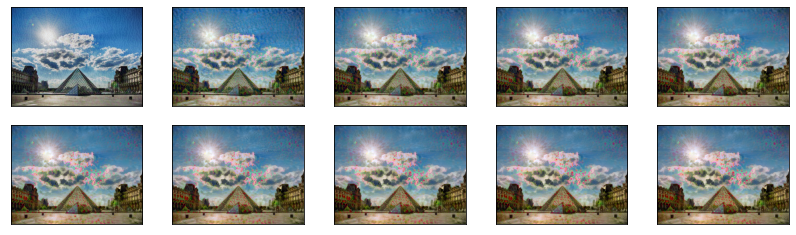

In [119]:
best_1, best_loss_1, history = run_style_transfer(content_path,style_path, num_iterations=200)
print('Custo =', best_loss_1)

**Saída esperada:**

    Custo = tf.Tensor(22014.047, shape=(), dtype=float32)

Execute a célula abaixo para visualizar o valor da função de custo total em função das épocas.

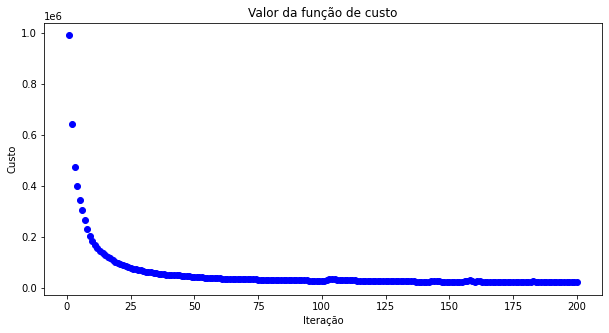

In [120]:
# Cria vetor de épocas e faz o gráfico do custo em função das épocas

tempo = range(1, len(history) + 1)
plt.figure(figsize=(10, 5))
plt.plot(tempo, history, 'bo')
plt.title('Valor da função de custo')
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.show()

### Visualização da imagem resultante

Para visualizar corretamente a imagem resultante devemos remover o processamento inicial realizado na imagem de conteúdo usando a função `imshow` definida no arquivo nst_utils2.py. Para fazer isso, execute a célula abaixo.

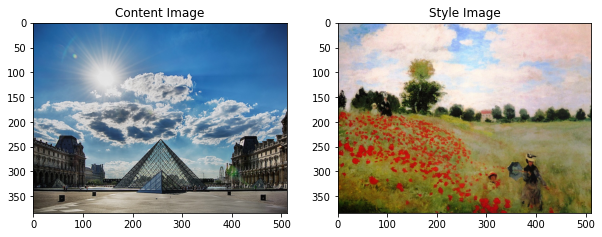

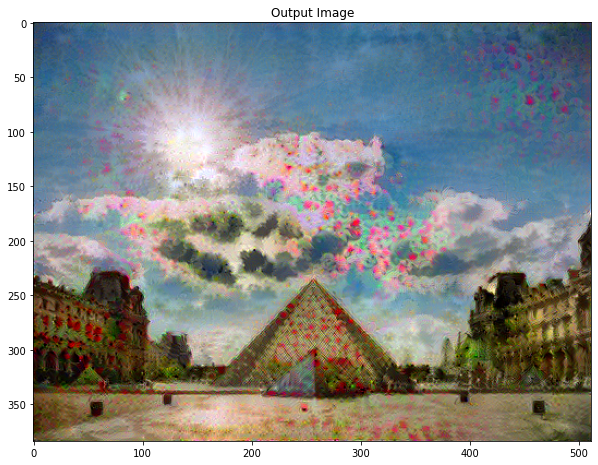

In [121]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path) 
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()    
        
show_results(best_1, content_path, style_path)          

## 7 - Testes com alterações dos parâmetros

Como visto em aula, a função de custo total consiste de uma média ponderada entre as parcelas referentes ao conteúdo e ao estilo, conforme a seguinte equação:

$$J(G) = \alpha J_C(S,G) + \beta J_S(S,G)$$

Veremos o que acontece se alterarmos os valores dos pesos das parcelas da função de custo relativas ao conteúdo ($\alpha$) e ao estilo ($\beta$).


### Exercício #6: Primeira alteração dos pesos das parcelas de conteúdo e estilo

Diminua o peso do custo de estilo para 20 e mantenha o peso do custo de conteúdo em 100 e execute novamente a função `run_style_transfer`. Observe que no programa $\alpha$ = `content_weight` e $\beta$ = `style_weight`.


Custo = tf.Tensor(8419.793, shape=(), dtype=float32)


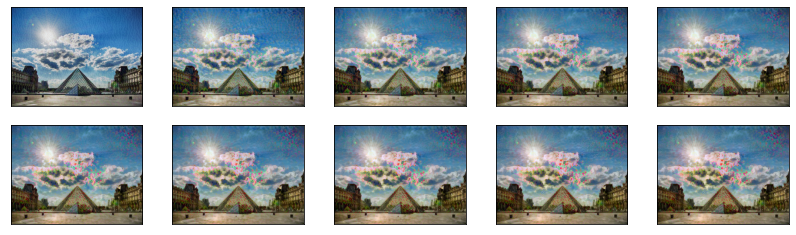

In [132]:
# PARA VOCÊ FAZER: Teste de transferência de estilo com novos parâmetros

# Altere as variáveis de ponderação das parcelas de conteúdo e de estilo da função de custo e
# execute execute novamente a função run_style_transfer
# alfa = content_weight
# beta = style_weight

### COMECE AQUI ### (≈ 1 linha)
best_2, best_loss_2, history2 = run_style_transfer(content_path, style_path, num_iterations=200, content_weight=20, style_weight=100)
### TERMINE AQUI ###

print('Custo =', best_loss_2)

**Saída esperada:**

    Custo = tf.Tensor(8438.926, shape=(), dtype=float32)

Execute a célula abaixo para visualizar a variação da função de custo durante o treinamento e a imagem resultante.

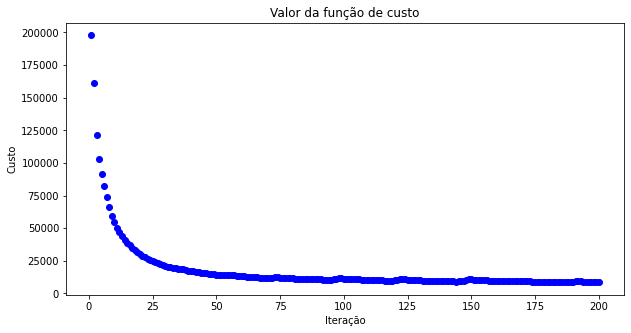

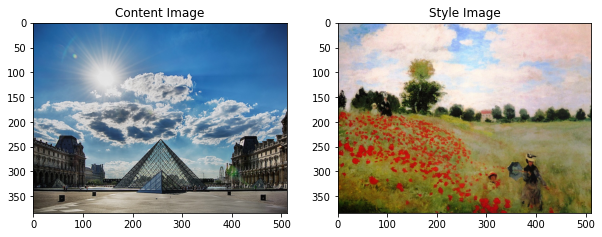

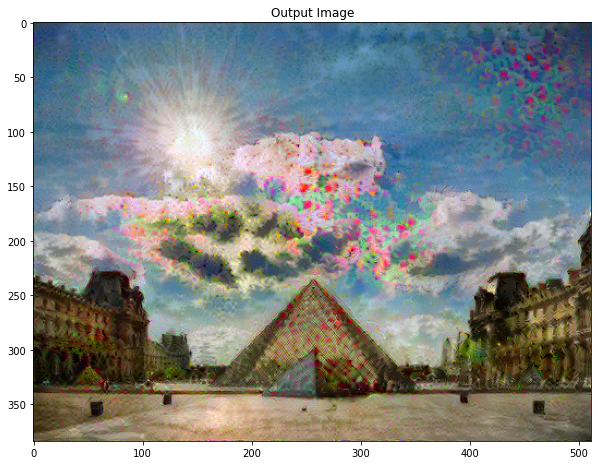

In [133]:
# Cria vetor de épocas e faz o gráfico da função de custo total em função das épocas

tempo = range(1, len(history2) + 1)
plt.figure(figsize=(10, 5))
plt.plot(tempo, history2, 'bo')
plt.title('Valor da função de custo')
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.show()

show_results(best_2, content_path, style_path)    

### Exercício #7: Segunda alteração dos pesos das parcelas de conteúdo e estilo

Aumente o peso do custo de estilo para 500 mantendo o peso do custo de conteúdo em 100 e execute novamente a função `run_style_transfer`.

Custo = tf.Tensor(63947.54, shape=(), dtype=float32)


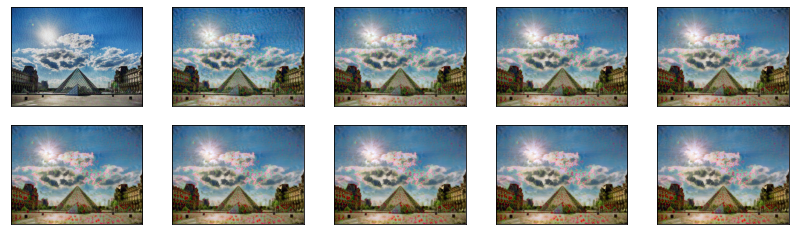

In [135]:
# PARA VOCÊ FAZER: Teste de transferência de estilo com novos parâmetros

# Altere as variáveis de ponderação das parcelas de conteúdo e de estilo da função de custo e
# execute execute novamente a função run_style_transfer
### COMECE AQUI ### (≈ 1 linha)
best_3, best_loss_3, history3 = run_style_transfer(content_path, style_path, num_iterations=200, content_weight=100, style_weight=500)
### TERMINE AQUI ###

print('Custo =', best_loss_3)

**Saída esperada:**

    Custo = tf.Tensor(66146.45, shape=(), dtype=float32)

Execute a célula abaixo para visualizar a variação da função de custo durante o treinamento e a imagem resultante.

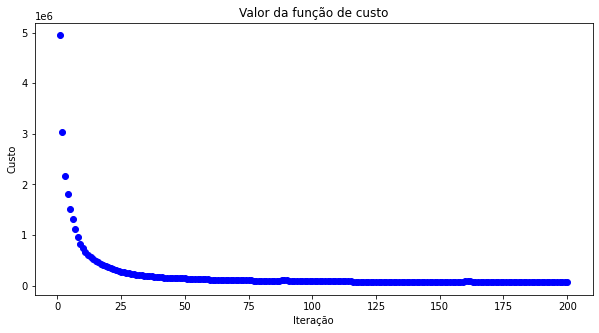

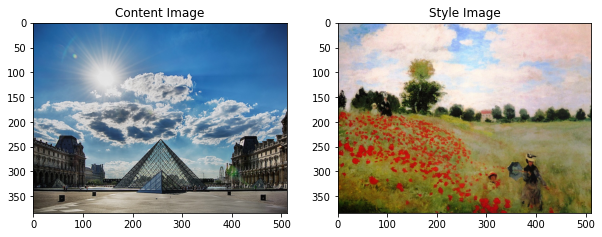

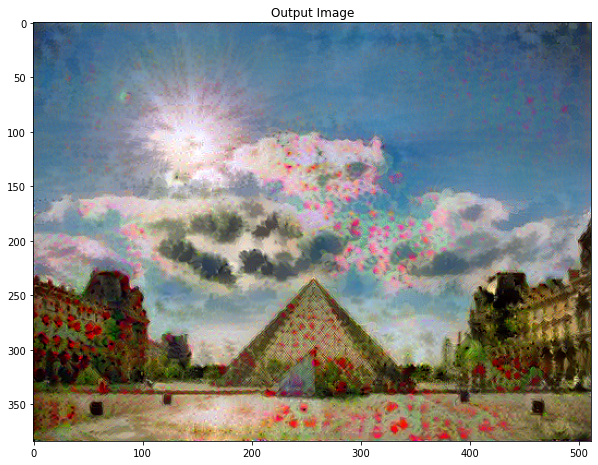

In [136]:
# Cria vetor de épocas e faz o gráfico da função de custo total em função das épocas

tempo = range(1, len(history3) + 1)
plt.figure(figsize=(10, 5))
plt.plot(tempo, history3, 'bo')
plt.title('Valor da função de custo')
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.show()

show_results(best_3, content_path, style_path)    

### Exercício #8: Alteração das camadas usadas para descrever conteúdo e estilo

Mantenha ambos os pesos do custo de estilo e de conteúdo iguais a 100 e altere as camadas utilizadas para definir o conteúdo e o estilo das imagens. 

Para representar o conteúdo use as camadas `block5_conv3`.

Para representar o estilo use as camdas `block1_conv2`, `block2_conv2`, `block3_conv2`, `block4_conv2` e `block5_conv2`.


Custo = tf.Tensor(7025.434, shape=(), dtype=float32)


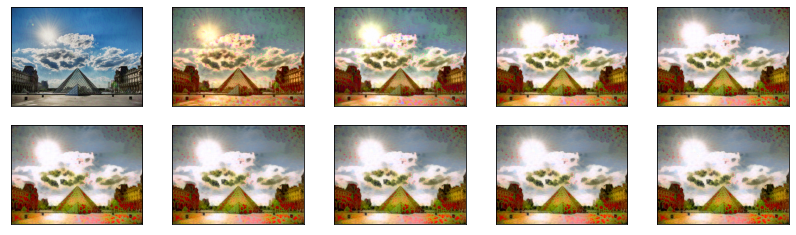

In [137]:
# PARA VOCÊ FAZER: Definir camadas de conteúdo e de estilo

# Camada de conteúdo
### COMECE AQUI ### (≈ 1 linha)
content_layers = ['block5_conv3']
### TERMINE AQUI ###

# Camadas de estilo. Inclua uma lista com os nomes das camadas
### COMECE AQUI ### (≈ 1 linha)
style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2','block5_conv2']
### TERMINE AQUI ###

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

print('Camadas de conteúdo:', content_layers)
print('Camadas de estilo:', style_layers)

# Execute a função de transferência de estilo 
### COMECE AQUI ### (≈ 1 linha)
best_4, best_loss_4, history4 = run_style_transfer(content_path, style_path, num_iterations=200, content_weight=100, style_weight=100)
### TERMINE AQUI ###

print('Custo =', best_loss_4)

**Saída esperada:**

    Custo = tf.Tensor(7504.194, shape=(), dtype=float32)

Execute a célula abaixo para visualizar a variação da função de custo durante o treinamento e a imagem resultante.

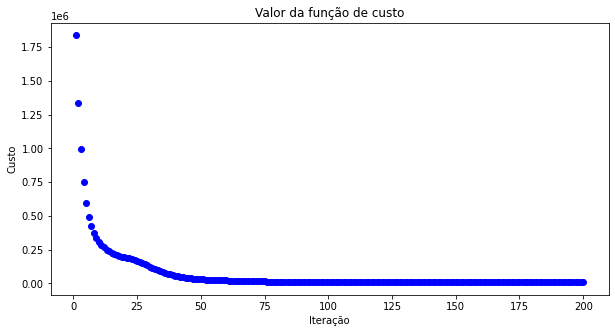

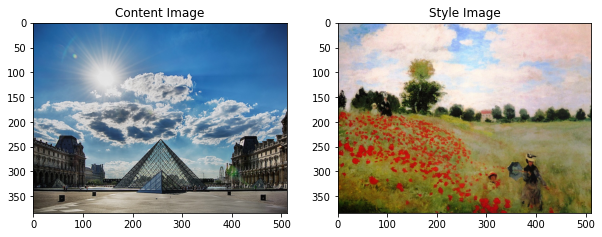

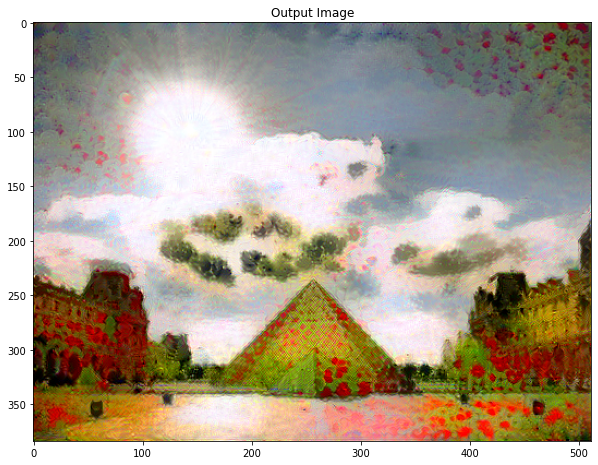

In [138]:
# Cria vetor de épocas e faz o gráfico da função de custo total em função das épocas

tempo = range(1, len(history4) + 1)
plt.figure(figsize=(10, 5))
plt.plot(tempo, history4, 'bo')
plt.title('Valor da função de custo')
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.show()

show_results(best_4, content_path, style_path)    

<font color='blue'>

## Conclusões:

1. Note que diminuir o peso da parcela do estilo na função de custo a imagem resultante vai parecer mais com a imagem de conteúdo, ou seja, menos estilo é transferida para a imagem gerada.

2. Ao contrário, se aumentar o peso da parcela do estilo na função de custo a imagem resultante vai parecer mais com a imagem de estilo, ou seja, mais estilo é transferida para a imagem gerada.

3. Conclui-se portanto que podemos controlar quanto de estilo transferimos para a nova imagem gerada simplesmente alterando os pesos das parcelas de conteúdo e de estilo da função de custo total.

4. Outra forma de controlar a transferência de estilo é escolher as camadas que definem o conteúdo e o estilo das imagens. O uso de ativações de camadas iniciais força a imagem gerada ser muito similar à imagem de conteúdo (C) e o uso de ativações das camadas mais profundas força a imagem gerada ser mais similar à imagem de estilo.

5. Outra forma de controlar o quanto de estilo é transferido para a imagem de conteúdo é usar um número de iterações menor ou maior. Essa técnica não foi testada nesse trabalho, mas você pode tentar fazer isso executando a função `run_style_transfer` com 1000 iterações. Após a entrega do trabalho faça isso e veja o resultado obtido.

## 8 - Teste com outras imagens

Tente transferir estilos para outras imagens. Os links a seguir possuem diversas imagens interssantes que podem ser usadas para transferência de estilo.

https://towardsdatascience.com/style-transfer-styling-images-with-convolutional-neural-networks-7d215b58f461
https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg
https://commons.wikimedia.org/wiki/File:The_Great_Wave_off_Kanagawa.jpg
https://commons.wikimedia.org/wiki/Commons:Featured_picture_candidates/Log/January_2005


### Exercício #9: Teste de transferência de estilo para outra imagem

Vamos testar o algoritmo de transferência de estilo com as imagens da cidade de São Francisco e Tytus. Essas imagens estão no diretório images com nomes sao_francisco.png e Tytus_Brzozowski.png.

Custo = tf.Tensor(32721.852, shape=(), dtype=float32)


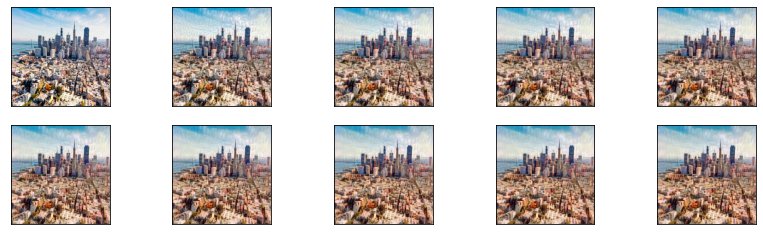

In [142]:
# PARA VOCÊ FAZER: Realizar a transferência de estilo da imagem Tytus para a imagem da cidade de São Francisco.

# Redefine as camadas de conteúdo e estilo originais
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

### COMECE AQUI ### (≈ 1 linha)
content_path = 'sao_francisco.png' 
style_path = 'Tytus_Brzozowski.png'
best_sao_franscisco, best_loss, history = run_style_transfer(content_path, style_path, num_iterations=200, content_weight=100, style_weight=100)
### TERMINE AQUI ###

print('Custo =', best_loss)

**Saída esperada:**

    Custo = tf.Tensor(32453.777, shape=(), dtype=float32)

Execute a célula abaixo para visualizar a imagem resultante.

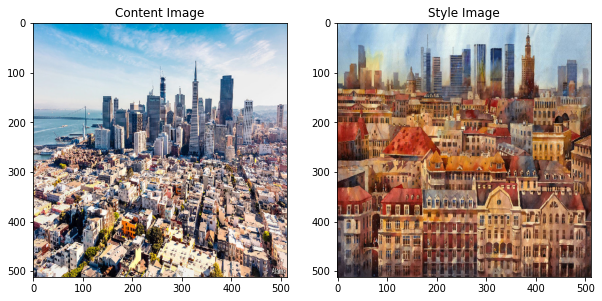

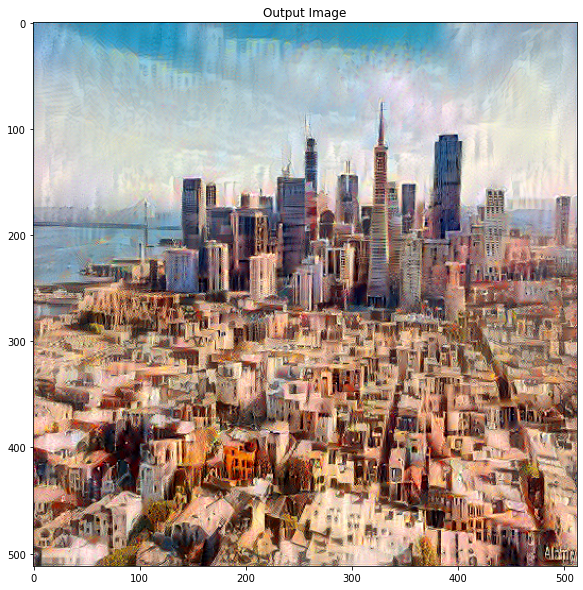

In [140]:
show_results(best_sao_franscisco, 'sao_francisco.png','Tytus_Brzozowski.png')

### Teste para outra imagem interessante

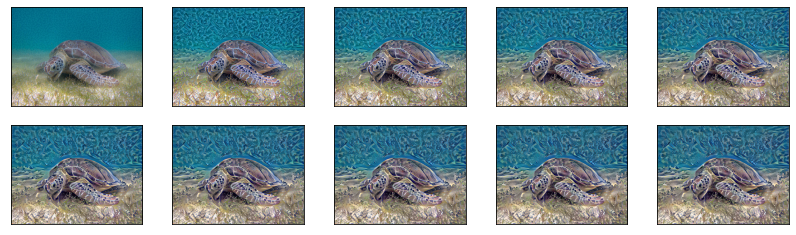

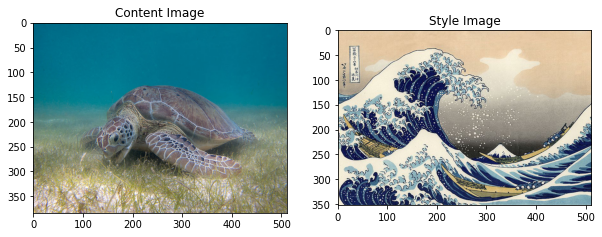

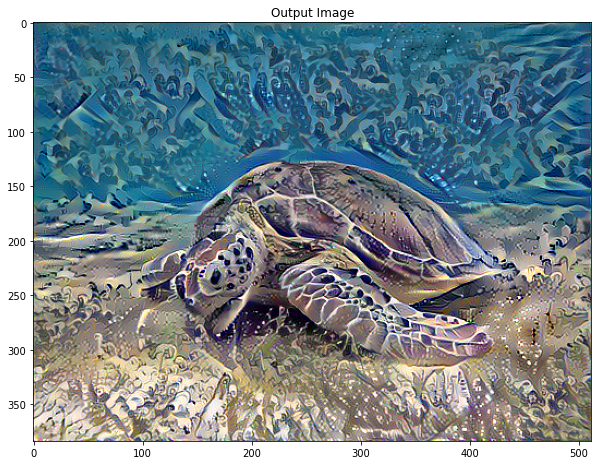

Custo = tf.Tensor(23610.531, shape=(), dtype=float32)


In [141]:
nst_turtle, best_loss, history = run_style_transfer('Green_Sea_Turtle.jpg','Great_Wave_off_Kanagawa.jpg',num_iterations=200)
show_results(nst_turtle, 'Green_Sea_Turtle.jpg','Great_Wave_off_Kanagawa.jpg')
print('Custo =', best_loss)